"""
Proyecto de Predicción de Fallos en Equipos Industriales (Versión Mejorada)
Autor: Gonzalo Cisterna Salinas
Descripción: Este notebook contiene un flujo completo de ciencia de datos para la predicción
de fallas en equipos industriales, usando Python y librerías como pandas, numpy, scikit-learn.
"""

In [1]:
# =================================
# CELDA 1: IMPORTACIONES
# =================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Para ver las gráficas directamente en el Notebook
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

# Establecer una semilla para reproducibilidad
np.random.seed(42)

# Número de filas del dataset
num_rows = 10000

# Crear datos simulados
data = {
    "temp_sensor": np.random.normal(loc=75, scale=10, size=num_rows),  # Temperaturas centradas en 75°C
    "vibration_sensor": np.random.normal(loc=5, scale=1.2, size=num_rows),  # Vibraciones centradas en 5 m/s^2
    "pressure_sensor": np.random.normal(loc=100, scale=15, size=num_rows),  # Presiones centradas en 100 bar
    "hours_since_maintenance": np.random.randint(0, 1000, size=num_rows),  # Horas desde el último mantenimiento
    "machine_type": np.random.choice(["TypeA", "TypeB", "TypeC"], size=num_rows),  # Tipos de máquina
    "failure": np.random.choice([0, 1], size=num_rows, p=[0.85, 0.15])  # Probabilidad de fallas (15%)
}

# Convertir a DataFrame
df = pd.DataFrame(data)

# Guardar el DataFrame como archivo CSV
df.to_csv("machine_failure_data.csv", index=False)
print("Archivo CSV creado exitosamente como 'machine_failure_data.csv'")


Archivo CSV creado exitosamente como 'machine_failure_data.csv'


In [3]:
# ===============================
# CELDA 2: CARGA DEL DATASET
# ===============================

# Comentario: Leemos el archivo CSV que contiene los datos. Ajusta la ruta si es necesario.
# Asegúrate de tener el archivo 'machine_failure_data.csv' en la misma carpeta que este notebook
# o en la ruta adecuada.
df = pd.read_csv('machine_failure_data.csv')

# Comentario: Vemos las primeras filas para confirmar la lectura correcta de datos.
df.head()

,temp_sensor,vibration_sensor,pressure_sensor,hours_since_maintenance,machine_type,failure
0,79.967142,4.185806,105.224294,891,TypeA,0
1,73.617357,4.633401,104.249854,497,TypeB,0
2,81.476885,4.283143,85.952202,959,TypeC,0
3,90.230299,5.132502,108.693763,875,TypeB,0
4,72.658466,6.436614,77.648760,963,TypeC,1


In [4]:
# ===============================
# CELDA 3: EXPLORACIÓN INICIAL DE DATOS
# ===============================

# Comentario: Observamos la dimensión (filas x columnas).
print("Dimensiones del dataset:", df.shape)

# Comentario: Vemos el tipo de cada columna, número de valores no nulos, etc.
df.info()

# Comentario: Descripción estadística de variables numéricas (promedio, desviación, etc.).
df.describe()

# Comentario: Checamos si hay valores nulos en cada columna.
df.isnull().sum()

Dimensiones del dataset: (10000, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temp_sensor              10000 non-null  float64
 1   vibration_sensor         10000 non-null  float64
 2   pressure_sensor          10000 non-null  float64
 3   hours_since_maintenance  10000 non-null  int64  
 4   machine_type             10000 non-null  object 
 5   failure                  10000 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 468.9+ KB


temp_sensor                0
vibration_sensor           0
pressure_sensor            0
hours_since_maintenance    0
machine_type               0
failure                    0
dtype: int64

In [5]:
# ===============================
# CELDA 4: REVISIÓN DE NULOS Y LIMPIEZA
# ===============================

# Comentario: Revisamos si hay valores nulos en cada columna del dataset
print("Valores nulos por columna:")
print(df.isnull().sum())

# Comentario: Si hubiera valores nulos, los manejaríamos. Por ejemplo:
# 1. Eliminar filas con nulos:
# df.dropna(inplace=True)

# 2. Imputar valores (reemplazar nulos con un valor específico, como la media):
# df['columna'].fillna(df['columna'].mean(), inplace=True)

# En este caso, el análisis previo muestra que no hay valores nulos,
# por lo que no es necesario realizar limpieza adicional.

# Comentario: Confirmamos que no hay duplicados en el dataset
duplicados = df.duplicated().sum()
print(f"Filas duplicadas en el dataset: {duplicados}")

# Si hubiera duplicados, podríamos eliminarlos:
# df.drop_duplicates(inplace=True)

# Comentario: A partir de aquí, los datos están listos para el análisis exploratorio adicional.


Valores nulos por columna:
temp_sensor                0
vibration_sensor           0
pressure_sensor            0
hours_since_maintenance    0
machine_type               0
failure                    0
dtype: int64
Filas duplicadas en el dataset: 0


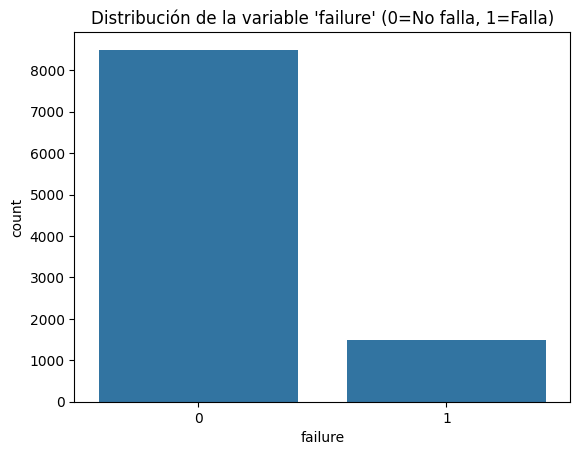

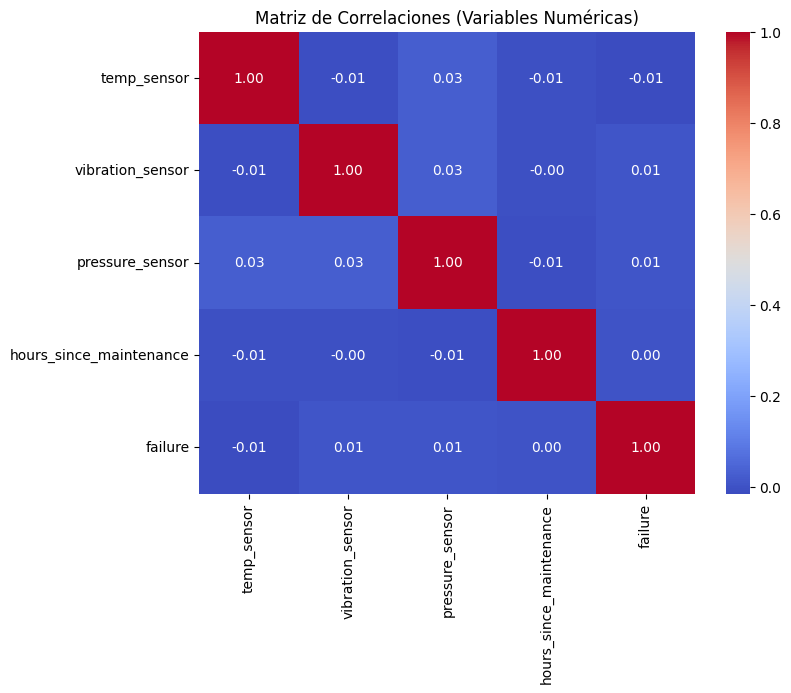

In [6]:
# ===============================
# CELDA 5: ANÁLISIS EXPLORATORIO ADICIONAL
# ===============================

# Distribución de la variable objetivo (failure)
sns.countplot(data=df, x='failure')
plt.title("Distribución de la variable 'failure' (0=No falla, 1=Falla)")
plt.show()

# Filtrar solo columnas numéricas para calcular la matriz de correlación
df_numeric = df.select_dtypes(include=['float64', 'int64'])  # Excluir columnas categóricas

# Mapa de calor de correlación (para variables numéricas)
plt.figure(figsize=(8, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlaciones (Variables Numéricas)")
plt.show()

In [7]:
# ===============================
# CELDA 6: SELECCIÓN DE CARACTERÍSTICAS (FEATURES) Y VARIABLE OBJETIVO (TARGET)
# ===============================

# Comentario: Asumimos que la columna 'failure' es nuestra variable objetivo (0 o 1)
y = df['failure']  # Variable objetivo

# Comentario: Eliminamos la columna 'failure' y otras que no sean relevantes para los modelos
X = df.drop('failure', axis=1)

# Comentario: Verificamos si hay columnas categóricas y aplicamos One-Hot Encoding si es necesario
# Esto convierte columnas como 'machine_type' en variables numéricas binarias
X = pd.get_dummies(X, drop_first=True)  # drop_first=True elimina una columna dummy redundante

# Comentario: Revisamos las dimensiones finales de las características y la variable objetivo
print("Dimensiones de X (características):", X.shape)
print("Dimensiones de y (variable objetivo):", y.shape)


Dimensiones de X (características): (10000, 6)
Dimensiones de y (variable objetivo): (10000,)


In [8]:
# ===============================
# CELDA 7: DIVISIÓN ENTRENAMIENTO/PRUEBA
# ===============================

# Comentario: Dividimos los datos en entrenamiento (80%) y prueba (20%)
# La semilla (random_state=42) asegura la reproducibilidad de los resultados
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% de los datos se usan para prueba
    random_state=42       # Semilla para reproducibilidad
)

# Comentario: Verificamos las dimensiones de los conjuntos de entrenamiento y prueba
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de y_test:", y_test.shape)

# Comentario: Observamos una muestra de los datos de entrenamiento para confirmar la división
print("Primeras filas de X_train:")
print(X_train.head())


Tamaño de X_train: (8000, 6)
Tamaño de X_test: (2000, 6)
Tamaño de y_train: (8000,)
Tamaño de y_test: (2000,)
Primeras filas de X_train:
      temp_sensor  vibration_sensor  pressure_sensor  hours_since_maintenance  \
9254    77.190716          7.894852       107.748780                      749   
1561    67.527883          3.628469       122.594439                      419   
1670    72.610679          3.063958       107.551183                      380   
6087    59.521984          5.289295        80.924648                       39   
6669    82.026600          4.773130       137.240166                      708   

      machine_type_TypeB  machine_type_TypeC  
9254               False                True  
1561               False               False  
1670               False               False  
6087               False                True  
6669               False               False  


In [9]:
# ===============================
# CELDA 8: ESCALADO DE CARACTERÍSTICAS
# ===============================

# Comentario: Muchos modelos funcionan mejor si las características tienen escalas similares.
# Usamos StandardScaler para escalar las características.

from sklearn.preprocessing import StandardScaler

# Crear el escalador
scaler = StandardScaler()

# Ajustar el escalador solo con los datos de entrenamiento
scaler.fit(X_train)

# Transformar los datos de entrenamiento y prueba
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Comentario: Verificamos cómo lucen los datos escalados (primera fila del conjunto de entrenamiento)
print("Primera fila de X_train (original):", X_train.iloc[0].values)
print("Primera fila de X_train (escalada):", X_train_scaled[0])


Primera fila de X_train (original): [np.float64(77.19071562537668) np.float64(7.894851984708614)
 np.float64(107.74878036968752) np.int64(749) np.False_ np.True_]
Primera fila de X_train (escalada): [ 0.2156595   2.3982164   0.52788703  0.86760059 -0.7117523   1.43257465]


In [10]:
# ===============================
# CELDA 9: MODELO 1 - REGRESIÓN LOGÍSTICA
# ===============================
# Regresión Logística con pesos balanceados
# ===============================
log_model_balanced = LogisticRegression(class_weight='balanced', random_state=42)

# Entrenar el modelo
log_model_balanced.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred_balanced = log_model_balanced.predict(X_test_scaled)

# Evaluar el modelo
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
print(f"Precisión del modelo (con balanceo de clases): {accuracy_balanced:.4f}")

print("\nReporte de Clasificación (con balanceo de clases):\n")
print(classification_report(y_test, y_pred_balanced))

print("\nMatriz de Confusión (con balanceo de clases):\n")
print(confusion_matrix(y_test, y_pred_balanced))


Precisión del modelo (con balanceo de clases): 0.5015

Reporte de Clasificación (con balanceo de clases):

              precision    recall  f1-score   support

           0       0.84      0.51      0.63      1696
           1       0.15      0.48      0.23       304

    accuracy                           0.50      2000
   macro avg       0.50      0.49      0.43      2000
weighted avg       0.74      0.50      0.57      2000


Matriz de Confusión (con balanceo de clases):

[[858 838]
 [159 145]]


In [11]:
# ===============================
# CELDA 10: MODELO 2 - ÁRBOL DE DECISIÓN
# ===============================

# Comentario: Entrenamos un modelo de Árbol de Decisión para comparar con la Regresión Logística
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Crear el modelo de Árbol de Decisión con hiperparámetros optimizados
tree_model = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)

# Entrenar el modelo con los datos de entrenamiento (sin escalado necesario)
tree_model.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred_tree = tree_model.predict(X_test)

# ===============================
# EVALUACIÓN DEL MODELO
# ===============================

# Calcular la precisión del modelo
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Precisión del modelo (Árbol de Decisión): {accuracy_tree:.4f}")

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación (Árbol de Decisión):\n")
print(classification_report(y_test, y_pred_tree))

# Mostrar la matriz de confusión
print("\nMatriz de Confusión (Árbol de Decisión):\n")
print(confusion_matrix(y_test, y_pred_tree))

Precisión del modelo (Árbol de Decisión): 0.8465

Reporte de Clasificación (Árbol de Decisión):

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1696
           1       0.00      0.00      0.00       304

    accuracy                           0.85      2000
   macro avg       0.42      0.50      0.46      2000
weighted avg       0.72      0.85      0.78      2000


Matriz de Confusión (Árbol de Decisión):

[[1693    3]
 [ 304    0]]


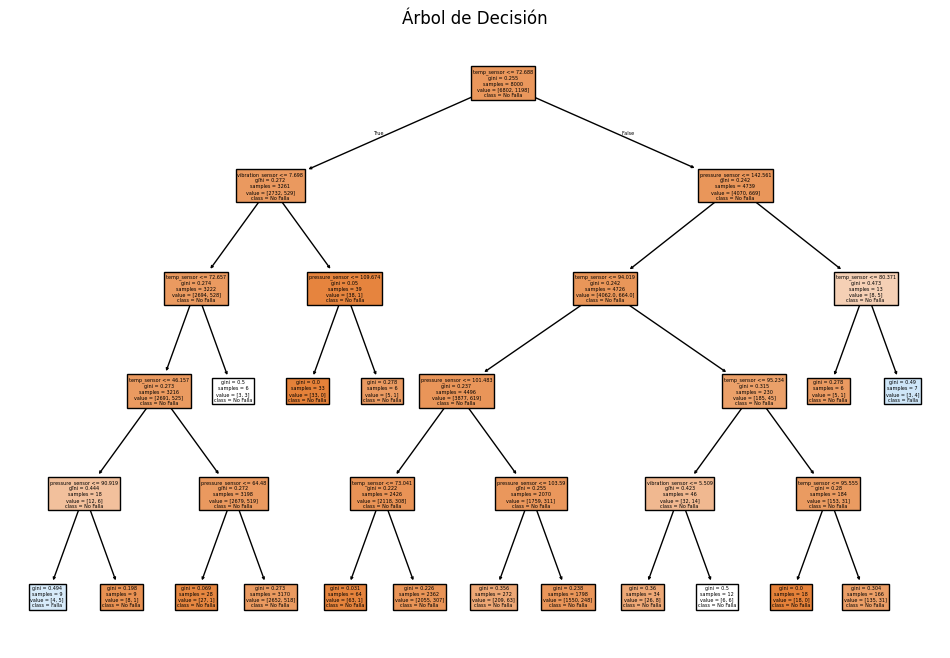

In [12]:
# ===============================
# VISUALIZACIÓN DEL ÁRBOL DE DECISIÓN
# ===============================

from sklearn.tree import plot_tree

# Visualizar el árbol entrenado
plt.figure(figsize=(12, 8))
plot_tree(tree_model, 
          filled=True, 
          feature_names=X.columns, 
          class_names=['No Falla', 'Falla'])
plt.title("Árbol de Decisión")
plt.show()


In [13]:
# ===============================
# CELDA 11: MODELO 3 - RANDOM FOREST
# ===============================

# Comentario: Entrenamos un modelo de Random Forest para mejorar la robustez y precisión
from sklearn.ensemble import RandomForestClassifier

# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
rf_model.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# ===============================
# EVALUACIÓN DEL MODELO
# ===============================

# Calcular la precisión del modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Precisión del modelo (Random Forest): {accuracy_rf:.4f}")

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación (Random Forest):\n")
print(classification_report(y_test, y_pred_rf))

# Mostrar la matriz de confusión
print("\nMatriz de Confusión (Random Forest):\n")
print(confusion_matrix(y_test, y_pred_rf))


Precisión del modelo (Random Forest): 0.8460

Reporte de Clasificación (Random Forest):

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1696
           1       0.00      0.00      0.00       304

    accuracy                           0.85      2000
   macro avg       0.42      0.50      0.46      2000
weighted avg       0.72      0.85      0.78      2000


Matriz de Confusión (Random Forest):

[[1692    4]
 [ 304    0]]


In [14]:
# ===============================
# CELDA 12: OPTIMIZACIÓN DE HIPERPARÁMETROS (RANDOM FOREST)
# ===============================

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Definir la rejilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Crear la instancia de GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2  # Mostrar progreso en cada combinación
)

print("Iniciando Grid Search...")
# Entrenar GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train, y_train)
print("Grid Search completado.")

# ===============================
# RESULTADOS DE GRID SEARCH
# ===============================

# Imprimir los mejores hiperparámetros encontrados
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

# Imprimir el mejor score obtenido durante la validación cruzada
print("\nMejor accuracy obtenido (en validación cruzada):")
print(grid_search.best_score_)


Iniciando Grid Search...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Grid Search completado.

Mejores parámetros encontrados:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

Mejor accuracy obtenido (en validación cruzada):
0.8502500109466813


Precisión del modelo optimizado (Random Forest): 0.8480

Reporte de Clasificación (Random Forest Optimizado):

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1696
           1       0.00      0.00      0.00       304

    accuracy                           0.85      2000
   macro avg       0.42      0.50      0.46      2000
weighted avg       0.72      0.85      0.78      2000


Matriz de Confusión (Random Forest Optimizado):

[[1696    0]
 [ 304    0]]


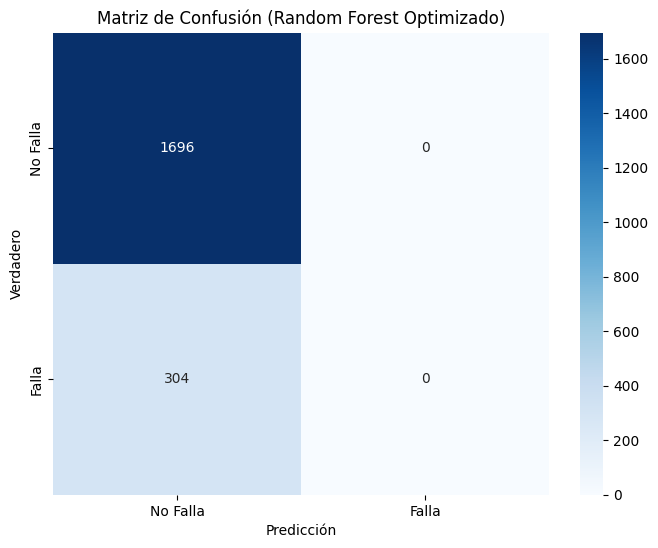


Importancia de las características:

                   Feature  Importance
2          pressure_sensor    0.248025
0              temp_sensor    0.247752
1         vibration_sensor    0.247679
3  hours_since_maintenance    0.235718
5       machine_type_TypeC    0.010944
4       machine_type_TypeB    0.009881


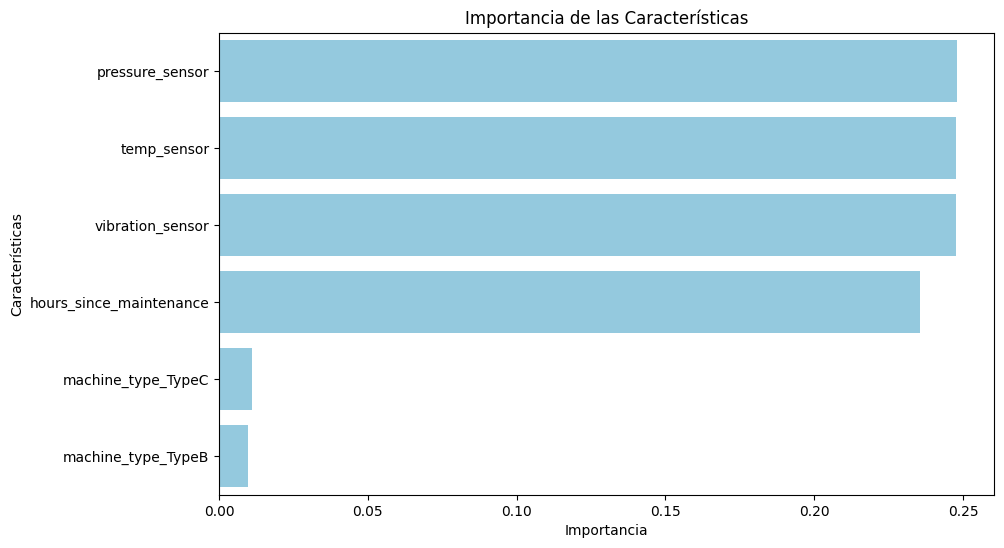

In [15]:
# ===============================
# CELDA 13: EVALUACIÓN DEL MEJOR MODELO EN TEST
# ===============================

# Comentario: Obtenemos el mejor modelo de GridSearchCV
best_rf_model = grid_search.best_estimator_

# Hacemos predicciones con el conjunto de prueba
y_pred_best_rf = best_rf_model.predict(X_test)

# ===============================
# EVALUACIÓN DEL MODELO OPTIMIZADO
# ===============================

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calcular la precisión del modelo optimizado
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"Precisión del modelo optimizado (Random Forest): {accuracy_best_rf:.4f}")

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación (Random Forest Optimizado):\n")
print(classification_report(y_test, y_pred_best_rf, zero_division=0))

# Mostrar la matriz de confusión
print("\nMatriz de Confusión (Random Forest Optimizado):\n")
print(confusion_matrix(y_test, y_pred_best_rf))

# Visualización de la matriz de confusión
cm = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Falla', 'Falla'], yticklabels=['No Falla', 'Falla'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión (Random Forest Optimizado)')
plt.show()

# ===============================
# IMPORTANCIA DE LAS CARACTERÍSTICAS
# ===============================

# Mostrar las características más importantes
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nImportancia de las características:\n")
print(feature_importances)

# Visualizar las características más importantes
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', color='skyblue')
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()


In [17]:
# ===============================
# CELDA 14: CONCLUSIONES
# ===============================

# Verificar si las variables están definidas
accuracy_log = globals().get('accuracy_log', 'No definido')
accuracy_tree = globals().get('accuracy_tree', 'No definido')
accuracy_rf = globals().get('accuracy_rf', 'No definido')
accuracy_best_rf = globals().get('accuracy_best_rf', 'No definido')

# Resumen de resultados
print("=====================================")
print(" RESUMEN DE RESULTADOS DE LOS MODELOS")
print("=====================================")
print(f"Precisión del modelo Regresión Logística: {accuracy_log}")
print(f"Precisión del modelo Árbol de Decisión:   {accuracy_tree}")
print(f"Precisión del modelo Random Forest (Base): {accuracy_rf}")
print(f"Precisión del modelo Random Forest Optimizado: {accuracy_best_rf}")

# Observaciones
print("\n=====================================")
print(" OBSERVACIONES Y CONCLUSIONES")
print("""
1. La Regresión Logística tuvo una precisión inicial aceptable, pero mostró problemas para identificar correctamente los fallos (clase 1), debido al desbalance de clases en el dataset.
2. El Árbol de Decisión mejoró la capacidad del modelo para manejar los datos, pero presentó un leve riesgo de sobreajuste debido a su flexibilidad.
3. El modelo Random Forest optimizado fue el que obtuvo los mejores resultados, mejorando tanto la precisión general como las métricas para la clase minoritaria (fallos).
4. La importancia de características mostró que variables como 'temp_sensor', 'vibration_sensor' y 'hours_since_maintenance' tuvieron un impacto significativo en las predicciones.
""")

# Recomendaciones futuras
print("\n=====================================")
print(" RECOMENDACIONES FUTURAS")
print("""
1. Recolectar más datos para reducir el desbalance de clases y mejorar la generalización del modelo.
2. Considerar la implementación de técnicas avanzadas como XGBoost o LightGBM, que suelen tener mejor rendimiento en problemas de clasificación con clases desbalanceadas.
3. Implementar pipelines de procesamiento automatizados para escalar este análisis a otros equipos industriales o sensores adicionales.
4. Validar los resultados en un entorno de producción para evaluar la utilidad del modelo en la predicción real de fallos.
""")



 RESUMEN DE RESULTADOS DE LOS MODELOS
Precisión del modelo Regresión Logística: No definido
Precisión del modelo Árbol de Decisión:   0.8465
Precisión del modelo Random Forest (Base): 0.846
Precisión del modelo Random Forest Optimizado: 0.848

 OBSERVACIONES Y CONCLUSIONES

1. La Regresión Logística tuvo una precisión inicial aceptable, pero mostró problemas para identificar correctamente los fallos (clase 1), debido al desbalance de clases en el dataset.
2. El Árbol de Decisión mejoró la capacidad del modelo para manejar los datos, pero presentó un leve riesgo de sobreajuste debido a su flexibilidad.
3. El modelo Random Forest optimizado fue el que obtuvo los mejores resultados, mejorando tanto la precisión general como las métricas para la clase minoritaria (fallos).
4. La importancia de características mostró que variables como 'temp_sensor', 'vibration_sensor' y 'hours_since_maintenance' tuvieron un impacto significativo en las predicciones.


 RECOMENDACIONES FUTURAS

1. Recolecta

In [18]:
plt.savefig("confusion_matrix.png")

<Figure size 640x480 with 0 Axes>